In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[]

In [2]:

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pandas import datetime
import os
import pandas as pd
import time
import warnings
import numpy as np
from numpy import newaxis
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pyedflib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings


# scale train and test data to [-1, 1]
def scale_t(data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = data.reshape(-1, 1)
    #scaler = StandardScaler()
    scaler = scaler.fit(data)
    # transform data
    print(data.shape[0])
    
    data_scaled = scaler.transform(data)
    
    return scaler, data_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X):
    X = X.reshape(-1,1)
    inverted = scaler.inverse_transform(X)
    return inverted[:, 0]

def load_data(filename):
    g = pyedflib.EdfReader(filename)
    n = g.signals_in_file
    signal_labels = g.getSignalLabels()
    sig = np.zeros((n, g.getNSamples()[0]))
    for i in np.arange(n):
        len_sig = len(g.readSignal(i))
        sig[i, :len_sig] = g.readSignal(i)
    return sig

def load_data_csv(filename, seq_len, normalise_window):
    f = pd.read_csv(filename,header=None)
    #data = f.decode().split('\n')
    num_channels = 2
    old_data = f.values
    old_data = old_data.reshape(-1,1)
    data = np.zeros((old_data.shape[0],num_channels))
    print(data.shape)
    data[:,0] = old_data[:,0]
    data[:,1] = old_data[:,0]
    data = data.T
    sequence_length = seq_len + 1
    result = chunk_data(data, sequence_length)

    if normalise_window:
        result = normalise_windows(result)

    #result = np.array(result)

    row = round(0.9 * result.shape[1])
    #print result[:,0]
    

    
    train = result[:,:int(row), :]
    np.random.shuffle(train)
    test = result[:,int(row):, :]
    old_x_train = train[:,:, :-1]
    y_train = train[:,:, -1]
    old_x_test = test[:,:, :-1]
    y_test = test[:,:, -1]

    x_train = np.zeros((old_x_train.shape[1], old_x_train.shape[2], old_x_train.shape[0]))
    for i in range(old_x_train.shape[1]):
        for k in range(old_x_train.shape[2]):
            vals = np.zeros(old_x_train.shape[0])
            for index in range(old_x_train.shape[0]):
                vals[index] = old_x_train[index,i,k]
                #print vals
            x_train[i,k] = vals
    
    x_test = np.zeros((old_x_test.shape[1], old_x_test.shape[2], old_x_test.shape[0]))
    for i in range(old_x_test.shape[1]):
        for k in range(old_x_test.shape[2]):
            vals = np.zeros(old_x_test.shape[0])
            for index in range(old_x_test.shape[0]):
                vals[index] = old_x_test[index,i,k]
            x_test[i,k] = vals

    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train,y_train.T, x_test, y_test.T]

def chunk_data(diff, sequence_length):
    chunk_data = np.zeros((diff.shape[0],diff.shape[1] - sequence_length, sequence_length))
    for index in range(diff.shape[1] - sequence_length):
        for k in range(diff.shape[0]):
            chunk_data[k,index] = diff[k,index: index + sequence_length]
    print(chunk_data[0,0])
    return chunk_data

def difference(datset, interval):
    diff = np.zeros((dataset.shape[0],dataset.shape[1]))
    for k in range(dataset.shape[0]):
        for i in range(interval, dataset.shape[1]):
            diff[k,i] = dataset[k,i] - dataset[k,i - interval]
    return diff
            

# create a differenced series
def normalize_all(result): 
    dataset = np.zeros(result.shape)
    for i in range(result.shape[0]):
        scaler, data_s = scale_t(result[i])
        dataset[i] = data_s[:,0]
    return dataset

def make_data(sig, seq_len, normalise_window):
    data = sig[:3,:10000]
    sequence_length = seq_len + 1
    if not normalise_window:
        #result = difference(data,1)
        scale = normalize_all(data)
        diff = chunk_data(scale, sequence_length)
    else:
        result = chunk_data(data, sequence_length)
        diff = normalise_windows(result)
    plt.plot(range(len(data[0,256:512])), data[0,256:512])
    plt.show()
    print(diff.shape)
    plt.plot(range(len(diff[0,256])), diff[0,256])
    plt.show()
    
    
    row = round(0.9 * diff.shape[1])
    
    train = diff[:,:int(row), :]
    test = diff[:,int(row):, :]
    
    
    #print(train_scaled.shape,test_scaled.shape)  
    #print(train_scaled[0],test_scaled[0])
    #np.random.shuffle(train)
    old_x_train = train[:,:, :-1]
    y_train = train[:,:, -1]
    old_x_test = test[:,:, :-1]
    y_test = test[:,:, -1]

    x_train = np.zeros((old_x_train.shape[1], old_x_train.shape[2], old_x_train.shape[0]))
    for i in range(old_x_train.shape[1]):
        for k in range(old_x_train.shape[2]):
            vals = np.zeros(old_x_train.shape[0])
            for index in range(old_x_train.shape[0]):
                vals[index] = old_x_train[index,i,k]
                #print vals
            x_train[i,k] = vals
    
    x_test = np.zeros((old_x_test.shape[1], old_x_test.shape[2], old_x_test.shape[0]))
    for i in range(old_x_test.shape[1]):
        for k in range(old_x_test.shape[2]):
            vals = np.zeros(old_x_test.shape[0])
            for index in range(old_x_test.shape[0]):
                vals[index] = old_x_test[index,i,k]
            x_test[i,k] = vals
    
    plt.plot(range(len(y_train[0,:256])), y_train[0,:256])
    plt.show()
    

    return [x_train, y_train.T, x_test, y_test.T]

In [3]:
def normalise_windows(window_data):
    normalised_data = np.zeros(window_data.shape)
    for i in range(window_data.shape[0]):
        for k in range(window_data.shape[1]):
            window = window_data[i,k]
            #print(window.shape)
            normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
            normalised_data[i,k] = normalised_window
    return normalised_data
        
def build_model(layers):
    model = Sequential()
    print(layers)
    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[3],
        return_sequences=True))
    #model.add(Dropout(0.2))

    model.add(keras.layers.GRU(
        layers[2],
        return_sequences=True))
    model.add(Dropout(0.2))
    
    #model.add(LSTM(
        #layers[2],
        #return_sequences=True))
    #model.add(Dropout(0.2))
    
    model.add(keras.layers.GRU(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss='mean_absolute_error', optimizer='rmsprop')
    print("> Compilation Time : ", time.time() - start)
    return model



In [4]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))

In [5]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    #predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [6]:
import time
import matplotlib.pyplot as plt

def plot_results(predicted_data, true_data, make_line):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    if make_line:
        plt.axvline(x=y_train.shape[0] + 1, linestyle='--', color = 'b', label = 'future predicted points')
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [7]:
global_start_time = time.time()
seq_len = 256

print('> Loading data... ')
sig = load_data('/datasets/home/78/878/earmand/final-project/sample-data/SC4002E0-PSG.edf')
#sig = load_data('sample-data/chb01_01.edf')
print(sig.shape)
#X_train, y_train, X_test, y_test = load_data_csv('sample-data/sp500.csv',seq_len,True)
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


> Loading data... 
(7, 8490000)


9743
9743
9743
10000
10000
10000
[-2.26700252e-01  2.20403023e-02 -1.25314861e-01 -7.55667506e-02
 -1.42947103e-01 -9.63476071e-02 -9.19395466e-02 -2.32997481e-02
 -1.22795970e-01 -1.10201511e-01 -5.28967254e-02 -5.03778338e-02
 -2.89672544e-02 -8.18639798e-03 -1.88916877e-03  3.27455919e-02
  9.50881612e-02  1.19017632e-01  7.61964736e-02  9.63476071e-02
  9.31989924e-02  8.81612091e-03  8.81612091e-03  2.95969773e-02
 -2.77555756e-17 -2.20403023e-02  5.98236776e-02 -2.95969773e-02
  5.35264484e-02  1.70025189e-02  8.81612091e-02  1.23425693e-01
  3.71536524e-02  1.61838791e-01  1.39798489e-01  2.45591940e-02
 -7.05289673e-02  5.79345088e-02 -5.22670025e-02 -1.15239295e-01
  8.56423174e-02  6.42317380e-02  9.44584383e-03  3.71536524e-02
  2.70780856e-02  1.45465995e-01  1.77581864e-01  7.24181360e-02
  9.50881612e-02  1.78211587e-01  1.53022670e-01  1.47984887e-01
  4.72292191e-02 -1.63727960e-02  1.25944584e-01  1.82619647e-01
  1.40428212e-01  8.50125945e-02  1.28463476e-01  6.92695

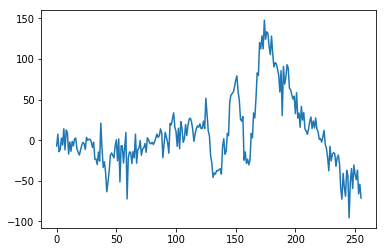

(3, 9743, 257)


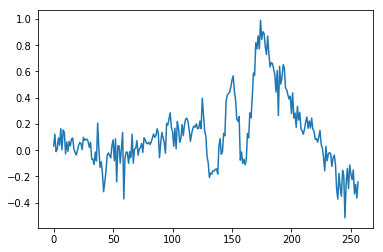

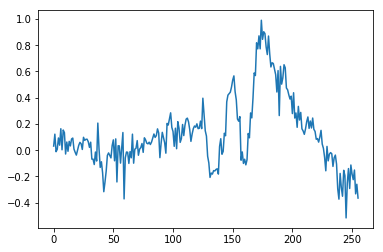

((8769, 256, 3), (8769, 3), (974, 256, 3), (974, 3))


In [8]:
scaler = []
for i in range(3):
    scale, data_y = scale_t(sig[i,257:10000])
    scaler.append(scale)
X_train, y_train, X_test, y_test = make_data(sig, seq_len, False)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9743, 1)


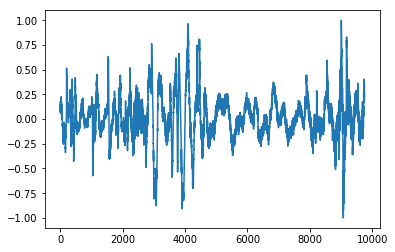

In [9]:
print data_y.shape
plt.plot(data_y)

In [10]:
print('> Data Loaded. Compiling...')
epochs  = 50
model = build_model([X_train.shape[2], X_train.shape[1], 50, X_train.shape[2]])
history = LossHistory()
filepath = 'save_model/weights_{epoch:02d}_rms.hdf5'
save_model = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=50)
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

#history = keras.callbacks.Callback()
model.fit(X_train, y_train, batch_size=800, nb_epoch=epochs, validation_split=0.05, callbacks=[history, save_model])

#predictions = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)


> Data Loaded. Compiling...
[3, 256, 50, 3]
('> Compilation Time : ', 0.031141996383666992)
Train on 8330 samples, validate on 439 samples
Epoch 1/50
8330/8330 [==============================] - 48s 6ms/step - loss: 0.1274 - val_loss: 0.0841
Epoch 2/50
8330/8330 [==============================] - 45s 5ms/step - loss: 0.1029 - val_loss: 0.0706
Epoch 3/50
8330/8330 [==============================] - 46s 6ms/step - loss: 0.0945 - val_loss: 0.0667
Epoch 4/50
8330/8330 [==============================] - 46s 6ms/step - loss: 0.0867 - val_loss: 0.0644
Epoch 5/50
8330/8330 [==============================] - 45s 5ms/step - loss: 0.0824 - val_loss: 0.0641
Epoch 6/50
8330/8330 [==============================] - 46s 5ms/step - loss: 0.0809 - val_loss: 0.0629
Epoch 7/50
8330/8330 [==============================] - 46s 6ms/step - loss: 0.0785 - val_loss: 0.0590
Epoch 8/50
8330/8330 [==============================] - 45s 5ms/step - loss: 0.0776 - val_loss: 0.0570
Epoch 9/50
8330/8330 [===============

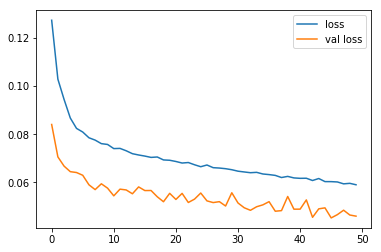

In [11]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(range(len(history.losses)),(np.array(history.losses)), label='loss')
plt.plot(range(len(history.val_losses)),(np.array(history.val_losses)), label='val loss') 
plt.legend()
plt.show()

In [18]:
print X_train.shape

(8769, 256, 3)


In [12]:
from keras.models import load_model
model = load_model('save_model/weights_50_rms.hdf5')
predicted_test = predict_point_by_point(model, X_test)        
predicted_train = predict_point_by_point(model, X_train)

    
   # plt.plot(predicted_test[:45,i] - predicted_train[:50, i])
    
   

('Training duration (s) : ', 2341.7785470485687)
(9743,)


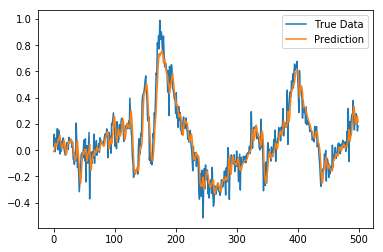

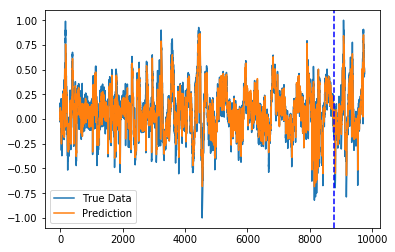

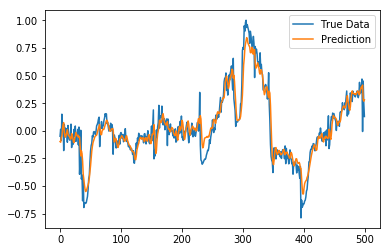

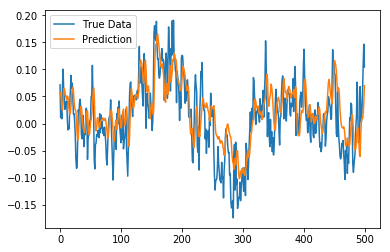

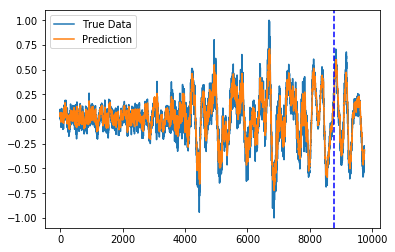

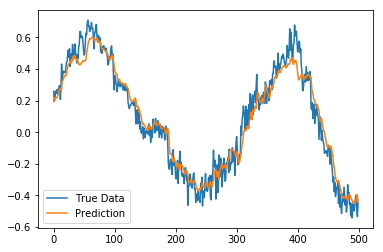

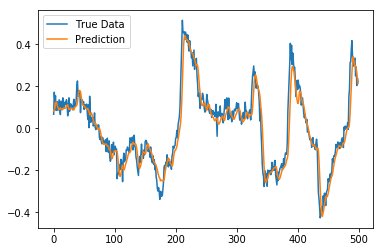

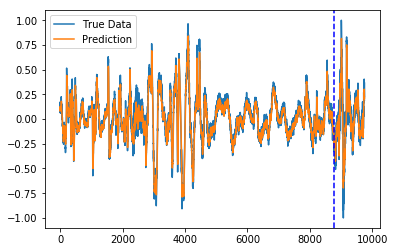

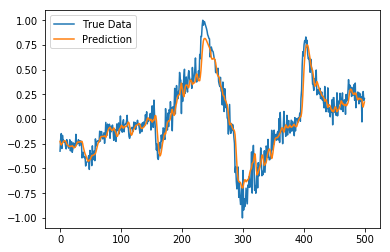

In [13]:
print('Training duration (s) : ', time.time() - global_start_time)
ex = np.concatenate([y_train[:,0],y_test[:,0]])
print ex.shape
true_data = np.zeros((3,len(ex)))
pred_data = np.zeros((3,len(ex)))
for i in range(X_train.shape[2]): 
    plot_results(predicted_train[:500, i], y_train[:500,i], False)
    true_data[i,:] = np.concatenate([y_train[:,i],y_test[:,i]])
    pred_data[i,:] = np.concatenate([predicted_train[:,i],predicted_test[:,i]])
    plot_results(pred_data[i,:], true_data[i,:], True)
    plot_results(predicted_test[:500,i], y_test[:500,i], False)

In [15]:
import pickle 
tot_time_length = 10000
seg_time_length = 10000 - seq_len
cut_off = int(0.9*seg_time_length)
nchannels = X_train.shape[2]
params = {'tot_time_length': tot_time_length, 'seg_time_length': seg_time_length, 'seq_len': seq_len, 'cut_off': cut_off, 'nchannels': nchannels}
data = {'true_data': true_data, 'pred_data': pred_data}
with open('/datasets/home/78/878/earmand/final-project/output-data/3channel_GRU_data_SC4002E0-PSG.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(params, f)
    pickle.dump(scaler, f)
    pickle.dump(pred_data, f)
    pickle.dump(true_data, f)
f.close()